# Train and test AVIDNet

In [1]:
import torch
from torch.utils.data import DataLoader
import os
from torchsummary import summary
from collections import defaultdict
from datasets.transforms import get_data_transforms
from datasets.utils import separate_datasets, show_samples,CovidDataLoader
from models.model import get_model
from models.train import train_model
from models.metrics import update_mean_metrics, print_metrics

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load data

In [3]:
cfg = {
    'purpose' : 'baseline',
    'data_dir' : './data/CXR',
    'mu' : 4,
    'fold' : 5,
    'epochs' : 20,
    'metric_types' : ['acc', 'ppv', 'recall', 'f1']
}
dataset_types = ['train', 'test']

if not os.path.exists(os.path.join(cfg['data_dir'],'test.txt')):
    from datasets.utils import make_baseline_dataset
    make_baseline_dataset('./data/CXR',25,outpath = cfg['data_dir']) # test는 전부, train은 25개 만큼만
if not os.path.exists(os.path.join(cfg['data_dir'],'train_lb_0.txt')):
    from datasets.utils import separate_datasets
    separate_datasets('./data/CXR', cfg['fold'], 25, cfg['mu'],outpath = cfg['data_dir']) # lb는 25개, ulb는 mu*25개
                      

In [4]:
loader_test = CovidDataLoader('train', cfg, fold_id=0)
class_names = loader_test.class_names

loader_test = DataLoader(loader_test, batch_size=1, num_workers=4, shuffle=True,
                              collate_fn=loader_test.collate_fn)

In [5]:
class_names

{0: 'Covid-19', 1: 'Pneumonia', 2: 'Normal'}

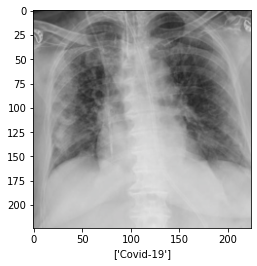

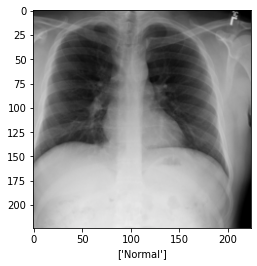

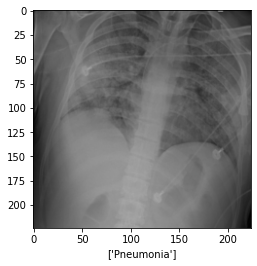

In [6]:
show_iteration = 3
show_samples(loader_test,class_names,show_iteration,cfg['mu'])

## Train the model

In [7]:
trained_models = []
cls_names = ['All', 'COVID-19', 'Pneumonia', 'Normal']

mean_metrics = {m_type: defaultdict(float) for m_type in cfg['metric_types']}
test_loader = CovidDataLoader('test', cfg)
dataset_sizes ={'test':len(test_loader)}
test_loader = DataLoader(test_loader, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=test_loader.collate_fn)
data_loaders ={'test':test_loader}


for i in range(cfg['fold']):
    train_loaders = CovidDataLoader('train', cfg)
    dataset_sizes['train']=len(train_loaders)
    train_loaders = DataLoader(train_loaders, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=train_loaders.collate_fn)
    data_loaders['train']=train_loaders

    model_ft, criterion, optimizer_ft, exp_lr_scheduler = get_model(device, fine_tuning=False)
    model, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, i, cls_names,
                                 cfg['metric_types'], dataset_types, data_loaders, dataset_sizes, device, num_epochs=cfg['epochs'],
                                 lambda_u=1.0, threshold=0.95, purpose=cfg['purpose'])
    trained_models.append(model)
    mean_metrics = update_mean_metrics(cls_names, mean_metrics, metrics, status='training')

mean_metrics = update_mean_metrics(cls_names, mean_metrics, status='final', fold=cfg['fold'])
print_metrics(mean_metrics, cls_names, phase='Mean results')

--------------------
Model 1
--------------------

Epoch 0/19
----------
[train]
LOSS - 1.1558
ACC - 0.3067
PPV - All: 0.0000  COVID-19: 0.4000  Pneumonia: 0.2941  Normal: 0.3056 
RECALL - All: 0.0000  COVID-19: 0.0800  Pneumonia: 0.4000  Normal: 0.4400 
F1 - All: 0.2777  COVID-19: 0.1333  Pneumonia: 0.3390  Normal: 0.3607 

[test]
LOSS - 1.1973
ACC - 0.0836
PPV - All: 0.0000  COVID-19: 0.0640  Pneumonia: 0.8696  Normal: 0.5600 
RECALL - All: 0.0000  COVID-19: 0.9800  Pneumonia: 0.0337  Normal: 0.0158 
F1 - All: 0.0719  COVID-19: 0.1202  Pneumonia: 0.0649  Normal: 0.0307 

Validation loss decreased (inf --> 1.197285).

Epoch 1/19
----------
[train]
LOSS - 1.0640
ACC - 0.4000
PPV - All: 0.0000  COVID-19: 0.3462  Pneumonia: 0.4444  Normal: 0.3846 
RECALL - All: 0.0000  COVID-19: 0.3600  Pneumonia: 0.6400  Normal: 0.2000 
F1 - All: 0.3803  COVID-19: 0.3530  Pneumonia: 0.5246  Normal: 0.2632 

[test]
LOSS - 0.8782
ACC - 0.5795
PPV - All: 0.0000  COVID-19: 0.8571  Pneumonia: 1.0000  Normal:

[train]
LOSS - 1.1166
ACC - 0.4400
PPV - All: 0.0000  COVID-19: 0.5455  Pneumonia: 0.4048  Normal: 0.4545 
RECALL - All: 0.0000  COVID-19: 0.2400  Pneumonia: 0.6800  Normal: 0.4000 
F1 - All: 0.4221  COVID-19: 0.3333  Pneumonia: 0.5075  Normal: 0.4255 

[test]
LOSS - 0.9592
ACC - 0.5921
PPV - All: 0.0000  COVID-19: 0.4103  Pneumonia: 0.0000  Normal: 0.6121 
RECALL - All: 0.0000  COVID-19: 0.6400  Pneumonia: 0.0000  Normal: 0.9842 
F1 - All: 0.4183  COVID-19: 0.5000  Pneumonia: 0.0000  Normal: 0.7548 

EarlyStopping counter: 1 out of 5

Epoch 2/19
----------
[train]
LOSS - 0.7836
ACC - 0.6533
PPV - All: 0.0000  COVID-19: 0.9474  Pneumonia: 0.5000  Normal: 0.6500 
RECALL - All: 0.0000  COVID-19: 0.7200  Pneumonia: 0.7200  Normal: 0.5200 
F1 - All: 0.6621  COVID-19: 0.8182  Pneumonia: 0.5902  Normal: 0.5778 

[test]
LOSS - 0.7033
ACC - 0.7739
PPV - All: 0.0000  COVID-19: 0.5484  Pneumonia: 0.8989  Normal: 0.7589 
RECALL - All: 0.0000  COVID-19: 0.6800  Pneumonia: 0.5387  Normal: 0.9424 
F

[test]
LOSS - 0.5576
ACC - 0.8043
PPV - All: 0.0000  COVID-19: 0.5130  Pneumonia: 0.7855  Normal: 0.8715 
RECALL - All: 0.0000  COVID-19: 0.7900  Pneumonia: 0.7828  Normal: 0.8203 
F1 - All: 0.7504  COVID-19: 0.6221  Pneumonia: 0.7841  Normal: 0.8451 

EarlyStopping counter: 4 out of 5

Epoch 16/19
----------
[train]
LOSS - 0.4387
ACC - 0.8800
PPV - All: 0.0000  COVID-19: 0.8800  Pneumonia: 0.8750  Normal: 0.8846 
RECALL - All: 0.0000  COVID-19: 0.8800  Pneumonia: 0.8400  Normal: 0.9200 
F1 - All: 0.8797  COVID-19: 0.8800  Pneumonia: 0.8571  Normal: 0.9020 

[test]
LOSS - 0.5686
ACC - 0.7999
PPV - All: 0.0000  COVID-19: 0.4659  Pneumonia: 0.8066  Normal: 0.8643 
RECALL - All: 0.0000  COVID-19: 0.8200  Pneumonia: 0.7441  Normal: 0.8350 
F1 - All: 0.7392  COVID-19: 0.5942  Pneumonia: 0.7741  Normal: 0.8494 

EarlyStopping counter: 5 out of 5

Early stopping!!

--------------------
[Best results]
ACC - 0.7999
PPV - All: 0.0000  COVID-19: 0.4659  Pneumonia: 0.8066  Normal: 0.8643 
RECALL -

[train]
LOSS - 1.0386
ACC - 0.4800
PPV - All: 0.0000  COVID-19: 0.4222  Pneumonia: 0.6667  Normal: 0.5000 
RECALL - All: 0.0000  COVID-19: 0.7600  Pneumonia: 0.3200  Normal: 0.3600 
F1 - All: 0.4646  COVID-19: 0.5428  Pneumonia: 0.4324  Normal: 0.4186 

[test]
LOSS - 0.7086
ACC - 0.6878
PPV - All: 0.0000  COVID-19: 0.0000  Pneumonia: 0.8506  Normal: 0.6555 
RECALL - All: 0.0000  COVID-19: 0.0000  Pneumonia: 0.3737  Normal: 0.9763 
F1 - All: 0.4346  COVID-19: 0.0000  Pneumonia: 0.5193  Normal: 0.7844 

Validation loss decreased (0.903282 --> 0.708581).

Epoch 2/19
----------
[train]
LOSS - 0.9908
ACC - 0.5067
PPV - All: 0.0000  COVID-19: 0.4444  Pneumonia: 0.4483  Normal: 0.6842 
RECALL - All: 0.0000  COVID-19: 0.4800  Pneumonia: 0.5200  Normal: 0.5200 
F1 - All: 0.5113  COVID-19: 0.4615  Pneumonia: 0.4815  Normal: 0.5909 

[test]
LOSS - 0.7395
ACC - 0.7783
PPV - All: 0.0000  COVID-19: 0.4813  Pneumonia: 0.8756  Normal: 0.7866 
RECALL - All: 0.0000  COVID-19: 0.7700  Pneumonia: 0.5926  

[train]
LOSS - 0.7493
ACC - 0.6800
PPV - All: 0.0000  COVID-19: 0.7600  Pneumonia: 0.6842  Normal: 0.6129 
RECALL - All: 0.0000  COVID-19: 0.7600  Pneumonia: 0.5200  Normal: 0.7600 
F1 - All: 0.6765  COVID-19: 0.7600  Pneumonia: 0.5909  Normal: 0.6786 

[test]
LOSS - 0.8230
ACC - 0.6295
PPV - All: 0.0000  COVID-19: 0.5100  Pneumonia: 0.5215  Normal: 0.9435 
RECALL - All: 0.0000  COVID-19: 0.5100  Pneumonia: 0.9411  Normal: 0.4339 
F1 - All: 0.5918  COVID-19: 0.5100  Pneumonia: 0.6711  Normal: 0.5944 

Validation loss decreased (0.953523 --> 0.823027).

Epoch 4/19
----------
[train]
LOSS - 0.6529
ACC - 0.6800
PPV - All: 0.0000  COVID-19: 1.0000  Pneumonia: 0.5349  Normal: 0.7895 
RECALL - All: 0.0000  COVID-19: 0.5200  Pneumonia: 0.9200  Normal: 0.6000 
F1 - All: 0.6808  COVID-19: 0.6842  Pneumonia: 0.6765  Normal: 0.6818 

[test]
LOSS - 0.9032
ACC - 0.6080
PPV - All: 0.0000  COVID-19: 0.2024  Pneumonia: 0.9655  Normal: 0.7464 
RECALL - All: 0.0000  COVID-19: 0.8600  Pneumonia: 0.0943  

## Save and load the model

In [11]:
out_dir = 'trained_models/baseline'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

for i, model in enumerate(trained_models):
    torch.save(model, f'trained_models/baseline/baseline_model_{i}.pt')

In [13]:
trained_model = []
for i in range(cfg['fold']):
    trained_models.append(torch.load(f'trained_models/baseline/baseline_model_{i}.pt'))
    
summary(trained_models[0], (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Reference

- https://tutorials.pytorch.kr/beginner/saving_loading_models.html
- https://stackoverflow.com/questions/42480111/model-summary-in-pytorch

## Evaluate the model - WIP (Work In Process)

In [ ]:
# def evaluate_model(model, criterion, optimizer):
#     since = time.time()

#     model.eval()   # Set model to evaluate mode

#     CLS = {0: 'COVID-19', 1: 'Pneumonia', 2: 'Normal'}
#     running_loss = 0.0
#     running_corrects = 0
#     acc, size, fp, fn = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)

#     # Iterate over data.
#     for inputs, labels in dataloaders['test']:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         # statistics
#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)
#         for pred, label in zip(preds, labels.data):
#             size[CLS[label.item()]] += 1
#             if pred == label.data:
#                 acc[CLS[label.item()]] += 1
#             else:
#                 fp[CLS[pred.item()]] += 1
#                 fn[CLS[label.item()]] += 1

#         iter_loss = running_loss / dataset_sizes['test']
#         iter_acc = running_corrects.double() / dataset_sizes['test']

#     print('Loss: {:.4f} Acc: {:.4f}'.format(iter_loss, iter_acc))
#     accs = {c: round(float(n) / size[c], 4) for c, n in acc.items()}
#     ppv = {c: round(float(n) / (acc[c] + sum([s for c_temp, s in fp.items()
#                                               if c_temp != c])), 4)
#            for c, n in acc.items()}
#     recall = {c: round(float(n) / (acc[c] + sum([s for c_temp, s in fn.items()
#                                                  if c_temp != c])), 4)
#               for c, n in acc.items()}
#     print(f'[ACC] COVID-19: {accs["COVID-19"]}, Pnuemonia: {accs["Pneumonia"]}, Normal: {accs["Normal"]}')
#     print(f'[PPV] COVID-19: {ppv["COVID-19"]}, Pnuemonia: {ppv["Pneumonia"]}, Normal: {ppv["Normal"]}')
#     print(f'[Recall] COVID-19: {recall["COVID-19"]}, Pnuemonia: {recall["Pneumonia"]}, Normal: {recall["Normal"]}')

#     time_elapsed = time.time() - since
#     print('Test complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))

In [ ]:
# evaluate_model(model_ft, criterion, optimizer_ft)